### Applying example from week 5

In [27]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import seaborn as sns
import torch

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
import itertools
palette = itertools.cycle(sns.color_palette())

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

# Load the data set
data = pd.read_csv('train_processed.csv')

Lets now preprocess the data by:
- Separating the inputs (x) from the targets (y)
- Standardizing the input variables in order to have zero mean and unit standard deviation

In [29]:
# Separate between features/inputs (X) and target/output variables (y)
mat = data.values
X = np.delete(mat, 1, axis=1)
print(X.shape)
y = mat[:, 1].astype("int")
print(y.shape)
ind = mat[:,1].astype("int")  #and get the indexes
print(ind.shape)

(1058, 53)
(1058,)
(1058,)


In [32]:
# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

The next step is to split our data into a train and test set. Alternatively, we could have used something like cross-validation, but for the sake of simplicity, a train/test split will do just fine for this example.

In [33]:
train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y)) # we also randomize the dataset
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 698
num test: 360


Just for the sake of comparision, lets run logistic regression from the popular sklearn package.

In [34]:
from sklearn.impute import SimpleImputer

# Create imputer (mean strategy works well for most numeric data)
imputer = SimpleImputer(strategy='mean')

# Fit to training data and transform both train and test
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)


In [35]:
# create and fit logistic regression model
logreg = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto', C=1)
logreg.fit(X_train, y_train)

# make predictions for test set
y_hat = logreg.predict(X_test)
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

predictions: [0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0
 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
true values: [0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0

In [36]:
def model(X, n_cat, obs=None):
    input_dim = X.shape[1]
    alpha = pyro.sample("alpha", dist.Normal(torch.zeros(1, n_cat), 
                                             5.*torch.ones(1, n_cat)).to_event())  # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(input_dim, n_cat), 
                                            5.*torch.ones(input_dim, n_cat)).to_event()) # Priors for the regression coeffcients
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Categorical(logits=alpha + X.matmul(beta)), obs=obs)
        
    return y

In [37]:
n_cat = 2
# Prepare data for Pyro
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()

In [41]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 40000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

y_train = y_train.long()

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, n_cat, y_train)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 4603.1
[1000] ELBO: 1114.9
[2000] ELBO: 564.6
[3000] ELBO: 516.7
[4000] ELBO: 490.6
[5000] ELBO: 478.5
[6000] ELBO: 470.6
[7000] ELBO: 485.3
[8000] ELBO: 470.5
[9000] ELBO: 455.4
[10000] ELBO: 466.4
[11000] ELBO: 445.9
[12000] ELBO: 460.6
[13000] ELBO: 450.8
[14000] ELBO: 440.5
[15000] ELBO: 448.2
[16000] ELBO: 443.6
[17000] ELBO: 442.5
[18000] ELBO: 459.5
[19000] ELBO: 473.2
[20000] ELBO: 433.2
[21000] ELBO: 424.1
[22000] ELBO: 432.3
[23000] ELBO: 425.5
[24000] ELBO: 433.2
[25000] ELBO: 430.3
[26000] ELBO: 423.7
[27000] ELBO: 427.7
[28000] ELBO: 440.2
[29000] ELBO: 445.0
[30000] ELBO: 432.3
[31000] ELBO: 411.1
[32000] ELBO: 435.4
[33000] ELBO: 444.1
[34000] ELBO: 417.4
[35000] ELBO: 438.7
[36000] ELBO: 402.0
[37000] ELBO: 427.6
[38000] ELBO: 406.4
[39000] ELBO: 452.2


Upon convergence, we can use the ```Predictive``` class to extract samples from posterior

In [42]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("alpha", "beta"))
samples = predictive(X_train, n_cat, y_train)

Plot posterior distributions for the parameters using the ```seaborn``` package

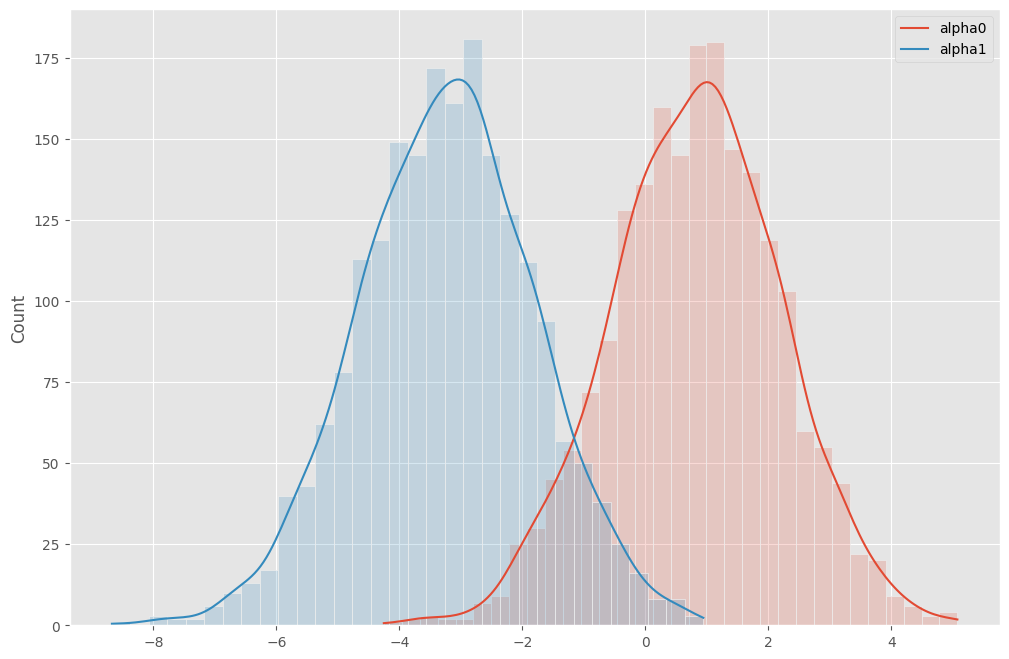

In [43]:
samples_alpha = samples["alpha"].detach().squeeze()
for c in range(n_cat):
    sns.histplot(samples_alpha[:,c], kde=True, alpha=0.2)
plt.legend(["alpha%d" % c for c in range(n_cat)])
plt.show()